<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

**Цель исследования** — на основе набора фотографий людей с указанием возраста необходимо для супермаркета «Хлеб-Соль» построить модель, которая по фотографии определит приблизительный возраст человека. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Ход исследования**

Исследование пройдёт в три этапа:
1. Проведение исследовательского анализа набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчет её качества.

**Описание данных:**

Набор данных находится в папке `/datasets/faces/`. В папке `/final_files` все изображения, в CSV-файле `labels.csv` две колонки: 

- `file_name` — имя файла

- **Целевой признак**: `real_age` — реальный возраст человека на фотографии

**Требования:**

Значение *MAE* должно быть меньше 8 (функцией потерь может быть MSE).

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from matplotlib import rcParams, rcParamsDefault
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rcParams['figure.figsize'] = 10,6

In [2]:
MY_RANDOM_STATE = np.random.seed(12345)

### Функции

Функция для построения диаграммы размаха.

In [3]:
def search_outliers(data, col, col_name=None):
    '''
    Функция принимает датафрейм и столбец, ищет выбросы с помощью IQR и строит boxplot
    data - датафрейм
    col - столбец датафрейма
    col_name - наименование столбца (для графика)
    Return:
    lower_fence - верхняя граница нормальных значений
    upper_fence - нижняя граница нормальных значений
    '''
    
    Q3 = np.quantile(data[col], 0.75, axis=0)
    Q1 = np.quantile(data[col], 0.25, axis=0)
    IQR = Q3 - Q1
    upper_fence = round(Q3 + 1.5 * IQR, 2)
    lower_fence = round(Q1 - 1.5 * IQR, 2)
    if round(Q1 - 1.5 * IQR, 2)<0:
        lower_fence = 0
    print('_' * 45)
    print(f'Интервал фактических значений для переменной {col} от {round(data[col].min(),2)} до {round(data[col].max(),2)}')
    print(f'Интервал нормальных значений для переменной {col} от {lower_fence} до {upper_fence}')

    print(f'Переменная {col} содержит аномальных значений : {round(data[(data[col]>upper_fence)| (data[col]<lower_fence)].shape[0]/data.shape[0]*100, 2)}%')

    if data[(data[col] == 0)].shape[0]>0:
        print(f'Переменная {col} содержит нулевые значения {round(data[(data[col] == 0)].shape[0]/data.shape[0]*100, 2)}%')
 
    #  строим диаграмму размаха    
    if col_name != None:
        data.loc[:, [col]].boxplot().set(title='Диаграмма размаха значений переменной {col_name}',
                                         ylabel=col_name) #  строим диаграмму размаха
        plt.show()
    
    return lower_fence, upper_fence

Функция, выводящая статистические характеристики для датафрейма.

In [4]:
def dataframe_information(data):
    '''
    Функция принимает датафрейм для анализа и возвращает датафрейм с основными статистиками данных
    data - датафрейм
    Return:
    df_res - датафрейм с характеристиками данных
    '''
    
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg'
               , 'mean', 'moda', 'std', 'min', 'max', 'out left', 'out rigth', '25%', '50%', '75%']
    
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
               
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = (column_na_values + column_zero_values) / data.shape[0]
        column_unique_values = data[column_name].nunique()
        column_negative_values = (data[column_name][data[column_name] < 0].count()
                                  if data[column_name].dtypes != 'object' else 0)
        column_mean = data[column_name].mean() if data[column_name].dtypes != 'object' else 0
        column_moda = statistics.mode(data[column_name])
        column_std = data[column_name].std() if data[column_name].dtypes != 'object' else 0
        column_min = data[column_name].min() if data[column_name].dtypes != 'object' else 0
        column_max = data[column_name].max() if data[column_name].dtypes != 'object' else 0
        outliers_left_number = (data[column_name][data[column_name] < data[column_name].quantile(.025)].count()
                                if data[column_name].dtypes != 'object' else 0)
        outliers_right_number = (data[column_name][data[column_name] > data[column_name].quantile(.975)].count()
                                 if data[column_name].dtypes != 'object' else 0)
        percentile_25 = data[column_name].quantile(.25) if data[column_name].dtypes != 'object' else 0
        percentile_50 = data[column_name].quantile(.50) if data[column_name].dtypes != 'object' else 0
        percentile_75 = data[column_name].quantile(.75) if data[column_name].dtypes != 'object' else 0
       
    # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values
                                 , column_zero_values, column_na_zero_rate, column_unique_values
                                 , column_negative_values, column_mean, column_moda, column_std, column_min
                                 , column_max, outliers_left_number, outliers_right_number
                                 , percentile_25, percentile_50, percentile_75])
    
    # формируем набор данных
    df_res = pd.DataFrame(data = df_data, columns = df_cols)
    
    return df_res

## Исследовательский анализ данных

Загрузим данные из файла `datasets/faces/labels.csv` в датафрейм `labels`, а так же с помощью загрузчика данных извлечем  фотографии из папки `/datasets/faces/final_files/`.

In [5]:
# чтение файла с данными и сохранение в labels
labels = pd.read_csv('/datasets/faces/labels.csv')
# создаем загрузчик данных
# сделаем предобработку данных: поделим значения яркости на 255
train_datagen = ImageDataGenerator(rescale=1./255)
# с помощью загрузчика извлекаем данные из папки
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=MY_RANDOM_STATE)

Found 7591 validated image filenames.


Было извечено 7591 фотография. 

Выведем первые 5 строк датафрейма labels.

In [6]:
# выведем первые 5 строк датафрейма labels
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Видим, что реальное содержание датафрейма соответствует описанию: содержится два поля с наименованием файла с фотографией человека и его реальный возраст.

Посмотрим основную информацию о датафрейме.

In [7]:
# выведем основную информацию о датафрейме labels
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в данных нет. Посмотрим размерность датафрейма.

In [8]:
# выведем на экран размеры датафрейма
labels.shape

(7591, 2)

Количество записей соответствует количеству фотографий.

Посмотрим статистические характеристики.

In [9]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [10]:
dataframe_information(labels)

,name,object,na,zero,rate,unique,neg,mean,moda,std,min,max,out left,out rigth,25%,50%,75%
0,file_name,object,0,0,0.0,7591,0,0.000000,000000.jpg,0.00000,0,0,0,0,0.0,0.0,0.0
1,real_age,int64,0,0,0.0,97,0,31.201159,30,17.14506,1,100,149,182,20.0,29.0,41.0


Видим, что есть выбвающиеся значения и слева, и справа, средний возраст - 31, самый частовстречающийся - 30. Есть младенцы, которые не придут самостоятельно в магазин за покупками.

Посмотрим на распределение возраста в выборке.

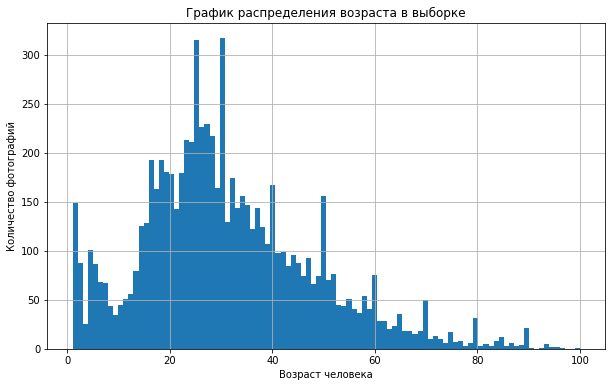

In [11]:
# построим распределение возраста
labels['real_age'].hist(bins=100) # строим гистограмму
# указываем наименования осей и графика
plt.xlabel('Возраст человека')
plt.ylabel('Количество фотографий')
plt.title('График распределения возраста в выборке')
plt.show()

Видим, что фотографий людей старше примерно 52 сильно снижается, после 60 лет фотографий достаточно мало. Фотографий в диапазоне от 18 до 40 лет больше всего.

Построим дополнительно боксплот.

_____________________________________________
Интервал фактических значений для переменной real_age от 1 до 100
Интервал нормальных значений для переменной real_age от 0 до 72.5
Переменная real_age содержит аномальных значений : 2.23%


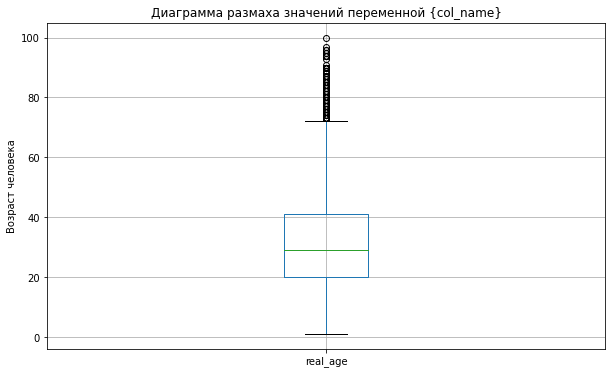

(0, 72.5)

In [12]:
search_outliers(labels, 'real_age', 'Возраст человека')

Видим, что фотографии людей старше 72 лет - это редкость.

Выведем на экран 16 фотографий.

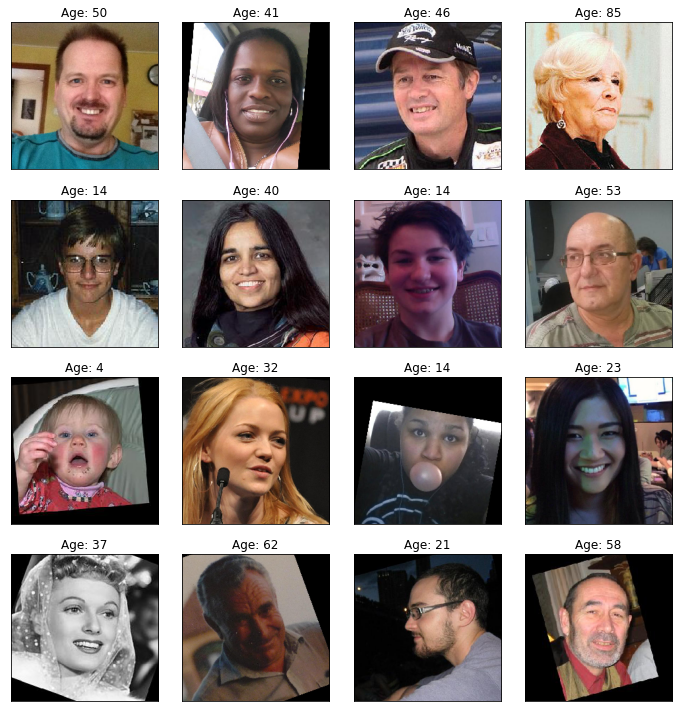

In [13]:
# получим пары картинки — метки
features, target = next(train_gen_flow)
# выводим на экран 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы:** описание данных соответствует реальному содержанию датасета: `file_name` содержит имя файла, `real_age` целевой признак, в формате int. 

Всего в датасете 7591 фотографий. Имеются изображения людей возрастом от 0 до 100 лет. Больше всего фотографий в диапазоне от 20 до 41 года. Фотографии людей старше 72 лет в наших данных являются редкими. Присутствуют фотографии, повернутые на некоторый угол. На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор, микрофон и т.д, что может усложнить оценку возраста. Визуально возраст соответствует фотографиям.

## Обучение модели

Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. 

Создадим 5 функций:
- `load_train(path)` - функция для загрузки обучающей выборки,
- `load_test(path)` - функция для загрузки тестовой выборки,
- `create_model(input_shape)` - функция для создания модели,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - функция длч обучения модели.

Применим архитектуру ResNet50.

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Результаты работы обученной модели.

```


2023-11-30 22:17:28.139342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-11-30 22:17:28.140954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-11-30 22:17:29.003838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-30 22:17:29.615389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-11-30 22:17:29.615458: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-30 22:17:29.615489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 22:17:29.617801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-30 22:17:29.618206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-11-30 22:17:29.620619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-11-30 22:17:29.621916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-11-30 22:17:29.621998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-30 22:17:29.625198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-11-30 22:17:29.797012: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-11-30 22:17:29.803654: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-11-30 22:17:29.804055: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59c6050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-30 22:17:29.804085: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-30 22:17:29.946836: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x58a3cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 22:17:29.946877: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-11-30 22:17:29.948528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-11-30 22:17:29.948585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-30 22:17:29.948595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 22:17:29.948622: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-30 22:17:29.948633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-11-30 22:17:29.948644: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-11-30 22:17:29.948654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-11-30 22:17:29.948663: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-30 22:17:29.951950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-11-30 22:17:29.952035: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-30 22:17:30.276586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-11-30 22:17:30.276645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-11-30 22:17:30.276655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-11-30 22:17:30.280172: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-11-30 22:17:30.280227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-11-30 22:17:40.646346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 22:17:40.944243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 48s - loss: 223.2642 - mae: 10.8750 - val_loss: 396.6473 - val_mae: 14.9506
Epoch 2/10
356/356 - 39s - loss: 66.9281 - mae: 6.2069 - val_loss: 141.7425 - val_mae: 8.8566
Epoch 3/10
356/356 - 38s - loss: 36.1032 - mae: 4.6658 - val_loss: 74.1154 - val_mae: 6.5401
Epoch 4/10
356/356 - 39s - loss: 24.1448 - mae: 3.7867 - val_loss: 86.6855 - val_mae: 6.8959
Epoch 5/10
356/356 - 39s - loss: 17.7333 - mae: 3.2538 - val_loss: 78.9123 - val_mae: 6.5054
Epoch 6/10
356/356 - 39s - loss: 14.0267 - mae: 2.8775 - val_loss: 71.2490 - val_mae: 6.3150
Epoch 7/10
356/356 - 39s - loss: 12.0676 - mae: 2.6188 - val_loss: 74.1897 - val_mae: 6.6581
Epoch 8/10
356/356 - 40s - loss: 10.8838 - mae: 2.5105 - val_loss: 70.9656 - val_mae: 6.2972
Epoch 9/10
356/356 - 41s - loss: 10.3076 - mae: 2.4374 - val_loss: 71.5906 - val_mae: 6.4889
Epoch 10/10
356/356 - 41s - loss: 9.3119 - mae: 2.3178 - val_loss: 68.4624 - val_mae: 6.2063
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 68.4624 - mae: 6.2063
Test MAE: 6.2063

```

## Анализ обученной модели

1. С помощью загрузчика данных были извлечены фотографии и осуществлена предобработка данных: значения яркости поделено на 255. Были проанализированы данные:
- общее количество 7591 изображений;
- в датасете фотографии людей возрастом от 0 до 100 лет;
- больше всего фотографий в диапазоне от 20 до 41 года;
- фотографии людей старше 72 лет - редкость;
- на фотографиях присутствуют предметы, частично закрывающие лицо человека.
2. Задача была определена, как регрессия. Целевым признаком является реальный возраст человека на фотографии - `real_age`.
3. Для решения задачи была обучена сверточная нейронная сеть, применена архитектура ResNet50, предобученная на датасете ImageNet. В выходном слое оставили один нейрон, который возвращает число-предсказание. Для него выбрали активацию ReLU - положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 быть не может.
4. Обученная модель  показала MAE: 6.2063, что удовлетворяет требованиям. Для людей старше 18 лет - это хороший показатель, так как при делении покупателей на категории в целях рекомендаций товаров, которые могут заинтересовать покупателей этой возрастной группы, погрешность в 6 лет не так страшна. Однако, при продаже алкогольной продукции данная погрешность может оказаться весьма существенной.